<a href="https://colab.research.google.com/github/Abkhenaten/Projects/blob/master/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import pickle
sns.set()

In [ ]:
# Read the data
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/train-data.csv')

Mounted at /content/drive


In [ ]:
#Look at the data
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [ ]:
#Drop unnamed column
data = train.drop('Unnamed: 0', axis=1)

In [ ]:
#Eliminate model from brand of car
data['Name'] = data['Name'].apply(lambda x: x.split(' ')[0].upper())

In [ ]:
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,MARUTI,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,HYUNDAI,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,HONDA,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,MARUTI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,AUDI,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [ ]:
#Substract year car was bought from present year to obtain years in use.
data['Year'] = dt.date.today().year - data['Year']

In [ ]:
# Select the first word of the Mileage column
data['Mileage'] =data['Mileage'].apply(lambda x: str(x).split(' ')[0])

# Change 'nan' string to real missing values
data['Mileage'] = [x if x != 'nan' else np.nan for x in data['Mileage']]

# Convert the datatype to floating numbers
data['Mileage'] = pd.to_numeric(data['Mileage'])

In [ ]:
# Select the first word of the Power column
data['Power'] = data['Power'].apply(lambda x: str(x).split(' ')[0])

# Change 'null' string to real missing values
data['Power'] = [np.nan if x=='null' else x for x in data['Power']]
data['Power'] = [np.nan if x=='nan' else x for x in data['Power']]

# Convert the datatype to floating numbers
data['Power'] = pd.to_numeric(data['Power'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   object 
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  Price              6019 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 564.4+ KB


In [ ]:
#Null values
data.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

In [ ]:
# Replace missing values with median value of the column
mileage_median = data['Mileage'].median()
data['Mileage'] = data['Mileage'].fillna(mileage_median)

power_median = data['Power'].median() 
data['Power'] = data['Power'].fillna(power_median)

seat_median = data['Seats'].median()
data['Seats'] = data['Seats'].fillna(seat_median)

# Drop the remaining rows with missing value
data.dropna(axis=0, inplace=True)

# Check for missing values
data.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

Exploratory Data Analysis

In [ ]:
# Classify the non-numerical features
cat_features = [x for x in data.columns if data[x].dtype == 'O']

# Classify the numerical features
num_features = [x for x in data.columns if data[x].dtype != 'O']

# Classify the discrete features
discrete_features = [x for x in num_features if len(data[x].unique()) < 25]

# Classify the continuous features
continuous_features = [x for x in num_features if x not in discrete_features]

# Review the features
print(f"Categorical features: {cat_features}\nNumerical features: {num_features}\
\nDiscrete features: {discrete_features}\nContinuous features: {continuous_features}")

Categorical features: ['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Engine']
Numerical features: ['Year', 'Kilometers_Driven', 'Mileage', 'Power', 'Seats', 'Price']
Discrete features: ['Year', 'Seats']
Continuous features: ['Kilometers_Driven', 'Mileage', 'Power', 'Price']


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


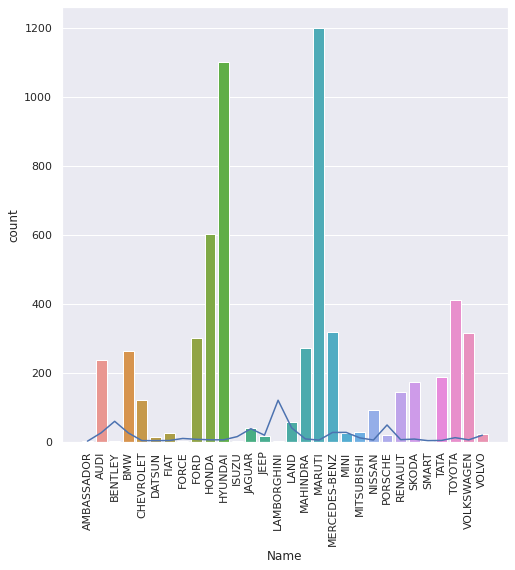

In [ ]:
#Visualize the data
plt.figure(figsize=(8,8))

# Count the number of times a car was bought and plot the graph
count = sns.countplot(cat_features[0], data=data, order=data.groupby('Name').mean()['Price'].index)
count.set_xticklabels(count.get_xticklabels(), rotation='vertical')

# Plot the mean price of each car
price = sns.lineplot(data.groupby('Name').mean()['Price'].index, data.groupby('Name').mean()['Price'].values);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

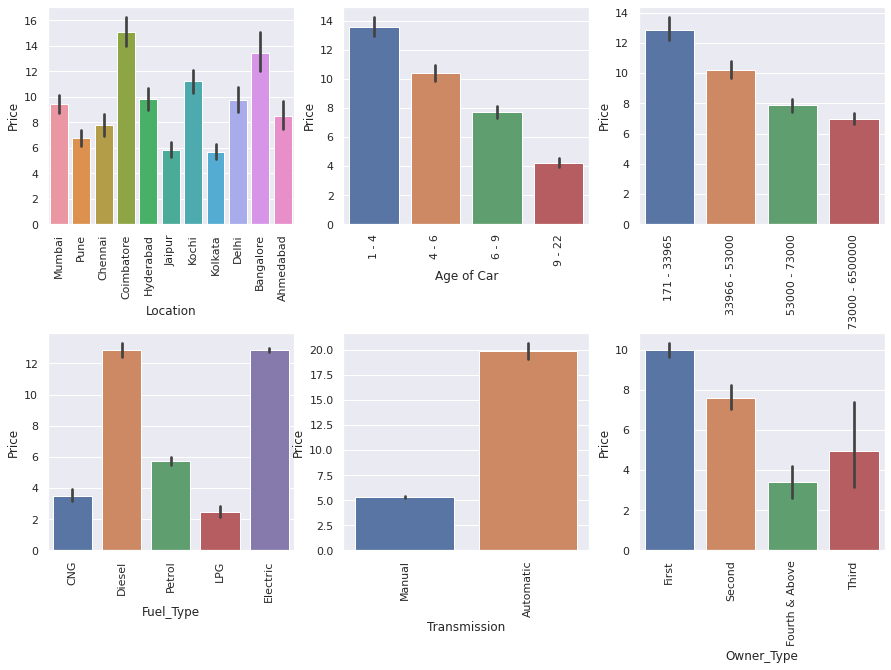

In [ ]:
# Create a figure with 6 subplots
fig, ax = plt.subplots(2,3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Graph each categorical feature wrt to thee Price
a = sns.barplot(data.columns[1], 'Price', data=data, ax=ax[0][0])
a.set_xticklabels(a.get_xticklabels(), rotation='vertical')

b = sns.barplot(pd.qcut(data[data.columns[2]], 4), 'Price', data=data, ax=ax[0][1])
b.set_xticklabels(['1 - 4', '4 - 6', '6 - 9', '9 - 22'], rotation='vertical')
b.set_xlabel('Age of Car')

c = sns.barplot(pd.qcut(data[data.columns[3]], 4), 'Price', data=data, ax=ax[0][2])
c.set_xticklabels(['171 - 33965', '33966 - 53000', '53000 - 73000', '73000 - 6500000'], rotation='vertical')

d = sns.barplot(data.columns[4], 'Price', data=data, ax=ax[1][0])
d.set_xticklabels(d.get_xticklabels(), rotation='vertical')

e = sns.barplot(data.columns[5], 'Price', data=data, ax=ax[1][1])
e.set_xticklabels(e.get_xticklabels(), rotation='vertical')

f = sns.barplot(data.columns[6], 'Price', data=data, ax=ax[1][2])
f.set_xticklabels(f.get_xticklabels(), rotation='vertical');

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


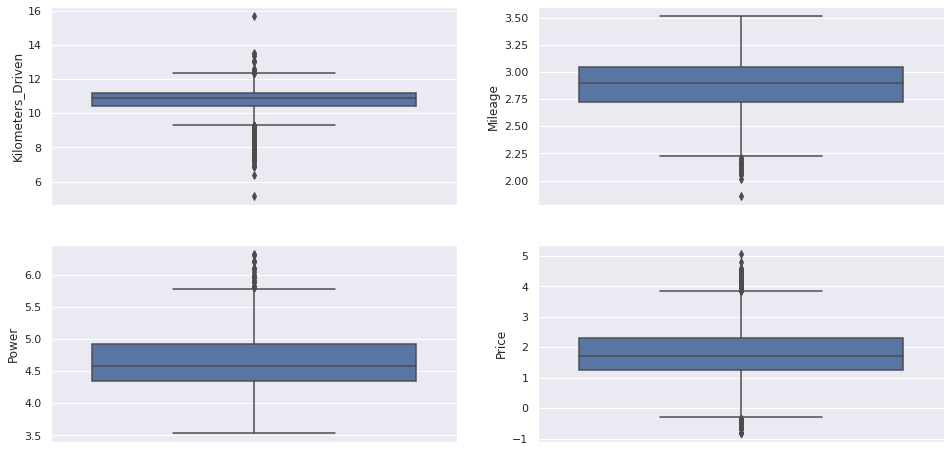

In [ ]:
#Check for outliers
data1 = data.copy()

# Create a figure with 4 subplots    
fig, ax = plt.subplots(2,2, figsize=(16,8))

#Create a boxplot for the continous features
box1 = sns.boxplot(y=np.log(data1[continuous_features[0]]), ax=ax[0][0])
box2 = sns.boxplot(y=np.log(data1[continuous_features[1]]), ax=ax[0][1])
box3 = sns.boxplot(y=np.log(data1[continuous_features[2]]), ax=ax[1][0])
box4 = sns.boxplot(y=np.log(data1[continuous_features[3]]), ax=ax[1][1]);

Features Engineering

In [ ]:
data = data.drop(['Location', 'Engine'], axis=1)
cat_features = [x for x in data.columns if data[x].dtype == 'O']
data = pd.get_dummies(data, cat_features)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Define the features or independent variable
X = data.drop(['Price'], axis=1)

# Define the label or dependent variable
y = data['Price']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Standard Scaler to the train data
scaler = StandardScaler()
scaler.fit(X_train[continuous_features[0:-1]])

# Transform Standard Scaler to the train and test data
X_train[continuous_features[0:-1]] = scaler.transform(X_train[continuous_features[0:-1]])
X_test[continuous_features[0:-1]] = scaler.transform(X_test[continuous_features[0:-1]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Model Evaluation

    Linear regressor finds a line that best fits all the features and predicts the output for a completely different input.
    
    Ridge regressor uses an L2 regularization technique to reduce the complexity of the model by coefficient shrinkage.
    
    Lasso regressor uses an L1 regularization technique to completely eliminate some features and make predictions.

    A decision tree regressor splits the data into smaller subdivisions. It asks questions about the data and provides yes or no answers. Each answer improves the confidence for a correct prediction.

    Decision tree aggregates the predictions of various random forest results to select a more stable prediction.

    K-fold cross-validation was used to check how these models would perform on our data.

In [ ]:
# Create a list of ML algorithms
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))

# Evalaute each model
for name, model in models:
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    score = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print(f"{name} has an r2 score: {np.round(score.mean(), 3)}%, and SD : {np.round(score.std(), 4)}")

Linear Regression has an r2 score: 0.735%, and SD : 0.0743
Ridge Regression has an r2 score: 0.734%, and SD : 0.0759
Lasso Regression has an r2 score: 0.642%, and SD : 0.0922
Decision Tree has an r2 score: 0.81%, and SD : 0.0699
Random Forest has an r2 score: 0.894%, and SD : 0.0392


Best result from Random Forrest at 89.55%

In [ ]:
# Check for model performance on the test data
rf = RandomForestRegressor() 
%time rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'r2 score: {np.round(r2_score(y_test, y_pred), 4)*100}%')
print(f'Mean absoluute error: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'Mean sqaured error: {metrics.mean_squared_error(y_test, y_pred)}')

CPU times: user 2.16 s, sys: 874 µs, total: 2.16 s
Wall time: 2.17 s
r2 score: 87.53999999999999%
Mean absoluute error: 1.6075770066038113
Mean sqaured error: 14.611561065393992


r2 score was 87.32% which was pretty good. 
The mean absolute error (1.60) and the mean squared error (14.87) were low.

Hyperparameter Tuning

In [ ]:
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', 'auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Define some paramters
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Apply RandomizedSearchCV with the defined paramters
model_search = RandomizedSearchCV(rf, param_distributions=params, scoring='r2')
%time model_search.fit(X_train, y_train)
y_pred_op = model_search.predict(X_test)

# Check metrics
print(r2_score(y_test, y_pred_op))


CPU times: user 7min 34s, sys: 1.29 s, total: 7min 36s
Wall time: 7min 36s
0.8772377064398068


Score increased to 87.76%

In [ ]:
# Define a function that implements the model
def predict_price(name, year, km, fuel, transmission, owner, mileage, power, seats):

# Define column location of the non numerical features
    name_index = np.where(X.columns=='Name_'+name.upper())[0][0]
    fuel_index = np.where(X.columns=='Fuel_Type_'+fuel)[0][0]
    transmission_index = np.where(X.columns=='Transmission_'+transmission)[0][0]
    owner_index = np.where(X.columns=='Owner_Type_'+owner)[0][0]

# Assign each of the inputted feature its value
    x = np.zeros(len(X.columns))
    x[0] = year
    x[1] = km
    x[2] = mileage
    x[3] = power
    x[4] = seats
    if name_index >= 0:
        x[name_index] = 1
    if fuel_index >= 0:
        x[fuel_index] = 1
    if transmission_index >= 0:
        x[transmission_index] = 1
    if owner_index >= 0:
        x[owner_index] = 1
    
    return f'The estimated price of the car is {model_search.predict([x])[0]} Lakh Rupees'

In [ ]:
predict_price('maruti', 10, 100000, 'Petrol', 'Manual', 'First', 30, 50, 7)

'The estimated price of the car is 30.426286413465004 Lakh Rupees'

In [ ]:
predict_price('toyota', 5, 30000, 'Petrol', 'Automatic', 'Second', 25, 150, 4)

'The estimated price of the car is 63.87054571541304 Lakh Rupees'

In [ ]:
predict_price('land', 3, 30000, 'Petrol', 'Automatic', 'First', 20, 250, 4)

'The estimated price of the car is 76.48002902236652 Lakh Rupees'